In [11]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import seaborn as sns
import math
%matplotlib inline

from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import ExtraTreesClassifier, VotingClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
import lightgbm as lgb

In [8]:
train = pd.read_csv('C:/Users/tmdwh/Desktop/SEUNGJO/dacon/competition_data/train.csv')
test = pd.read_csv('C:/Users/tmdwh/Desktop/SEUNGJO/dacon/competition_data/test.csv')
submission = pd.read_csv('C:/Users/tmdwh/Desktop/SEUNGJO/dacon/competition_data/submission.csv', index_col = 0)

In [10]:
# 결측치 확인
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 70 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   index         15000 non-null  int64  
 1   Q1            14959 non-null  float64
 2   Q2            14931 non-null  float64
 3   Q3            14950 non-null  float64
 4   Q4            14929 non-null  float64
 5   Q5            14962 non-null  float64
 6   Q6            14952 non-null  float64
 7   Q7            14924 non-null  float64
 8   Q8            14952 non-null  float64
 9   Q9            14944 non-null  float64
 10  Q10           14928 non-null  float64
 11  Q11           14941 non-null  float64
 12  Q12           14933 non-null  float64
 13  Q13           14960 non-null  float64
 14  Q14           14964 non-null  float64
 15  Q15           14955 non-null  float64
 16  Q16           14967 non-null  float64
 17  Q17           14963 non-null  float64
 18  Q18           14937 non-nu

In [730]:
#nan 값을 전부 0으로 처리
#train.fillna(0, inplace=True)
#test.fillna(0, inplace=True)

In [731]:
# 질문의 유형별로 분류
# VCL의 응답은 0, 1로
# question 1 ~ 5 사이의 값
# TIPI 1 ~ 7 사이의 값
VCL_columns = ['VCL' + str(x + 1) for x in range(16)]
question_columns = ['Q' + str(x + 1) for x in range(26)]
TIPI_columns = ['TIPI' + str(x + 1) for x in range(10)]

survey_columns = []
survey_columns.extend(question_columns)
survey_columns.extend(TIPI_columns)

# 카테고리별로 분류
categorical_columns = ['gender', 'engnat', 'hand', 'religion', 'orientation', 'voted', 'married', 'ASD', 'urban', 'nerdiness', 'education', 'country']
elapse_columns = ['introelapse', 'testelapse', 'surveyelapse', 'familysize']
numerical_columns = [column for column in train.columns if column not in categorical_columns]


# [카테고리] 결측값 -> 최빈값으로 변경
for category in categorical_columns:
    if category != 'nerdiness':
        train[category] = train[category].fillna(train[category].mode()[0])
        test[category] = test[category].fillna(test[category].mode()[0])
        train[category] = train[category].astype('str')
        test[category] = test[category].astype('str')
    else:
        train[category] = train[category].fillna(train[category].mode()[0])
        train[category] = train[category].astype('str')

'''
# [categorical]
for category in categorical_columns:
    train.loc[train[category] == 0, category] = train[category].mean()
    test.loc[test[category] == 0, category] = test[category].mean()
  '''  
  
# 연속형 변수 : float32, 결측값 -> 응답 : 3 (중간 값[이도저도 아니다])
for survey in survey_columns:
    train[survey] = train[survey].astype('float32')
    train[survey] = train[survey].fillna(3)
    test[survey] = test[survey].astype('float32')
    test[survey] = test[survey].fillna(3)

# 시간 관련 변수 -> 중앙값(중위값)으로 [median]
for elapse in elapse_columns:
    train[elapse] = train[elapse].astype('float32')
    train[elapse] = train[elapse].fillna(train[elapse].median())
    test[elapse] = test[elapse].astype('float32')
    test[elapse] = test[elapse].fillna(test[elapse].median())


In [732]:
train.columns

Index(['index', 'Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8', 'Q9', 'Q10',
       'Q11', 'Q12', 'Q13', 'Q14', 'Q15', 'Q16', 'Q17', 'Q18', 'Q19', 'Q20',
       'Q21', 'Q22', 'Q23', 'Q24', 'Q25', 'Q26', 'country', 'introelapse',
       'testelapse', 'surveyelapse', 'TIPI1', 'TIPI2', 'TIPI3', 'TIPI4',
       'TIPI5', 'TIPI6', 'TIPI7', 'TIPI8', 'TIPI9', 'TIPI10', 'VCL1', 'VCL2',
       'VCL3', 'VCL4', 'VCL5', 'VCL6', 'VCL7', 'VCL8', 'VCL9', 'VCL10',
       'VCL11', 'VCL12', 'VCL13', 'VCL14', 'VCL15', 'VCL16', 'education',
       'urban', 'gender', 'engnat', 'age', 'hand', 'religion', 'orientation',
       'voted', 'married', 'familysize', 'ASD', 'nerdiness'],
      dtype='object')

In [733]:
# 마키아벨리즘에 대한 질문 점수
makia_survey = ['Q' + str(i+1) for i in range(20)]
not_makia = ['Q3', 'Q4', 'Q6','Q7', 'Q9', 'Q10', 'Q11', 'Q14', 'Q16', 'Q17', 'Q18']
# 'Q6', 'Q14', 'Q18'
# 'Q21', 'Q22', 'Q23', 'Q23', 'Q24', 'Q25', 'Q26'은 secret question이라 제외

for columns in not_makia:
    train.loc[train[columns] > 0, columns] = 6 - train[columns]
    test.loc[test[columns] > 0, columns] = 6 - test[columns]



# 기준치 (60점 이상)에 관련된 파생변수 생성
train['makia_score'] = np.sum(train[makia_survey], axis = 1)
test['makia_score'] = np.sum(test[makia_survey], axis = 1)

train['high_makia'] = train['makia_score'].apply(lambda x : (1 if x > 60 else 0))
test['high_makia'] = test['makia_score'].apply(lambda x : (1 if x > 60 else 0))

train['high_makia'] = train['high_makia'].astype('str')
test['high_makia'] = test['high_makia'].astype('str')

In [735]:
'''
 TIPI에 대한 질문 점수
 TIPI는 1 ~ 7점까지 존재 -> 1 ~ 5점으로 변환
 TIPI 1점 -> 1점
 TIPI 2점 -> 2점
 TIPI 3점 -> 3점
 TIPI 4점 -> 3점
 TIPI 5점 -> 3점
 TIPI 6점 -> 4점 
 TIPI 7점 -> 5점
'''
TIPI_score = {1:1, 2:2, 3:4, 3:5, 4:6, 5:7}


for tipi in TIPI_columns:
    train[tipi] = train[tipi].map(TIPI_score)
    test[tipi] = test[tipi].map(TIPI_score)

train[TIPI_columns].describe()

,TIPI1,TIPI2,TIPI3,TIPI4,TIPI5,TIPI6,TIPI7,TIPI8,TIPI9,TIPI10
count,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
mean,3.751267,4.563400,5.229400,4.851333,5.795333,5.463467,5.312800,4.520667,4.739667,3.012867
std,2.054510,1.802091,1.500975,1.870044,1.140087,1.590357,1.487157,1.904297,1.760180,1.948270
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,2.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,2.000000,5.000000,1.000000
50%,5.000000,5.000000,5.000000,5.000000,6.000000,6.000000,5.000000,5.000000,5.000000,2.000000
75%,5.000000,6.000000,6.000000,6.000000,7.000000,7.000000,6.000000,6.000000,6.000000,5.000000
max,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000


In [737]:
test[TIPI_columns].describe()

,TIPI1,TIPI2,TIPI3,TIPI4,TIPI5,TIPI6,TIPI7,TIPI8,TIPI9,TIPI10
count,35452.000000,35452.000000,35452.000000,35452.000000,35452.000000,35452.000000,35452.000000,35452.000000,35452.000000,35452.000000
mean,3.738153,4.527897,5.200468,4.840742,5.802663,5.468070,5.316315,4.535372,4.749662,2.978816
std,2.065309,1.817297,1.526410,1.873197,1.139026,1.575324,1.510887,1.903089,1.768045,1.945080
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,2.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,2.000000,5.000000,1.000000
50%,5.000000,5.000000,5.000000,5.000000,6.000000,6.000000,5.000000,5.000000,5.000000,2.000000
75%,5.000000,6.000000,6.000000,6.000000,7.000000,7.000000,6.000000,6.000000,6.000000,5.000000
max,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000


In [738]:
'''
TIPI 관련 파생변수 생성

성실성 : {3번 점수 + (8 - '8번 점수')} ÷ 2
우호성 : {7번 점수 + (8 - '2번 점수')} ÷ 2
정서적 안정성(점수가 낮으면 신경성과 관련): {9번 점수 + (8 - '4번 점수')} ÷ 2
개방성 : {5번 점수 + (8 - '10번 점수')} ÷ 2
외향성 : {1번 점수 + (8 - '6번 점수')} ÷ 2
'''

train['성실성'] = (train['TIPI3'] + 8 - train['TIPI8']) / 2
train['우호성'] = (train['TIPI7'] + 8- train['TIPI2']) / 2
train['정서적 안정성'] = (train['TIPI9'] + 8 - train['TIPI4']) / 2
train['개방성'] = (train['TIPI5'] + 8 - train['TIPI10']) / 2
train['외향성'] = (train['TIPI1'] + 8 - train['TIPI6']) / 2


test['성실성'] = (test['TIPI3'] + 8 - test['TIPI8']) / 2
test['우호성'] = (test['TIPI7'] + 8- test['TIPI2']) / 2
test['정서적 안정성'] = (test['TIPI9'] + 8 - test['TIPI4']) / 2
test['개방성'] = (test['TIPI5'] + 8 - test['TIPI10']) / 2
test['외향성'] = (test['TIPI1'] + 8 - test['TIPI6']) / 2

In [740]:
# Q1 ~ Q20 사이에 Tactivcs, Views, Morality와 관련된 파생변수 생성
train['Tactics'] = train['Q1'] + train['Q2'] + train['Q3'] + train['Q7'] + train['Q10'] + train['Q12'] + train['Q15'] + train['Q16'] 
train['Views'] = train['Q5'] + train['Q4'] + train['Q8'] + train['Q11'] + train['Q13'] + train['Q17'] + train['Q20'] 
train['Morality'] = train['Q19'] + train['Q9'] 


test['Tactics'] = test['Q1'] + test['Q2'] + test['Q3'] + test['Q7'] + test['Q10'] + test['Q12'] + test['Q15'] + test['Q16'] 
test['Views'] = test['Q5'] + test['Q4'] + test['Q8'] + test['Q11'] + test['Q13'] + test['Q17'] + test['Q20'] 
test['Morality'] = test['Q19'] + test['Q10'] 

In [742]:
# age에 대한 이상치 처리
train.loc[train['age'] > 99, 'age'] = 0
test.loc[test['age'] > 99, 'age'] = 0

In [743]:
# EDA 결과 50대 이상일수록 nerdiness가 1인 비율이 많아짐. => 관련 파생변수 생성
# children = 1
# adult = 2
# middle age = 3
# old age = 4
def age_to_category(age):
    normalize = age // 10
    if normalize == 1:
        return 1
    elif (normalize >= 2) & (normalize <= 4):
        return 2
    elif (normalize >= 5) & (normalize <= 6):
        return 3
    else:
        return 4

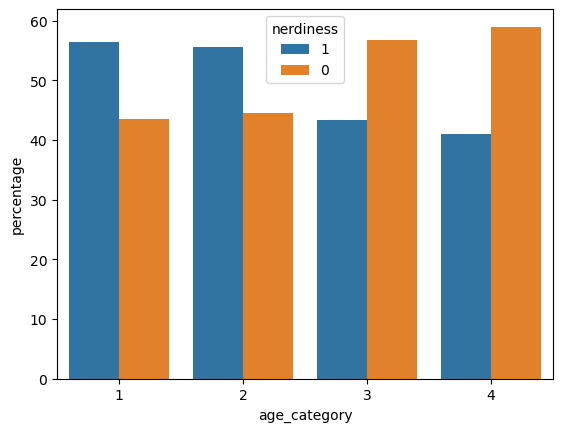

In [744]:
train['age_category'] = train['age'].apply(lambda x : age_to_category(x))
counts = train.groupby('age_category')['nerdiness'].value_counts(normalize = True).rename('percentage').mul(100).reset_index()
sns.barplot(x = 'age_category', y = 'percentage', hue = 'nerdiness', data = counts)
test['age_category'] = test['age'].apply(lambda x : age_to_category(x))


In [745]:
# 특정 종교와 관련하여 nerdiness 변화가 뚜렷함.
def convert_environment(x):
    if ((x == '2.0') | (x == '5.0') | (x == '9.0')):
        return '0'
    elif ((x == '1.0') | (x == '12.0') | (x == '6.0') | (x == '7.0')):
        return '1'
    else:
        return '2'


# 기존 코드의 범위에서 범위 수정
def convert_env(x):
    if ((x == '2.0') | (x == '5.0') | (x == '9.0')):
        return '0'
    elif ((x == '1.0') | (x == '12.0') | (x == '6.0') | (x == '7.0')):
        return '1'
    elif ((x == '3.0') | (x == '4.')):
        return '2'
    else:
        return '3'


train['religion_environment'] = train['religion'].apply(lambda x : convert_env(x))
test['religion_environment'] = test['religion'].apply(lambda x : convert_env(x))

In [746]:
#train['religion_environment'] = train['religion'].apply(lambda x : convert_env(x))
#train['religion_environment'] = train['religion']
#counts = train.groupby('religion_environment')['nerdiness'].value_counts(normalize = True).rename('percentage').mul(100).reset_index()
#sns.barplot(x = 'religion_environment', y = 'percentage', hue = 'nerdiness', data = counts)
#test['religion_environment'] = test['religion'].apply(lambda x : convert_env(x))


In [747]:
# age, religion -> 삭제
train.drop(['age', 'religion'], axis = 1, inplace = True)
test.drop(['age', 'religion'], axis = 1, inplace = True)

In [748]:

# elapse (설문조사 시간)은 상관 관계가 적다고 판단하여 drop
# index columns도 제거
drop_list = ['introelapse', 'testelapse', 'surveyelapse', 'index']
train.drop(drop_list, axis = 1, inplace = True)
test.drop(drop_list, axis = 1, inplace = True)


train.columns


Index(['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8', 'Q9', 'Q10', 'Q11',
       'Q12', 'Q13', 'Q14', 'Q15', 'Q16', 'Q17', 'Q18', 'Q19', 'Q20', 'Q21',
       'Q22', 'Q23', 'Q24', 'Q25', 'Q26', 'country', 'TIPI1', 'TIPI2', 'TIPI3',
       'TIPI4', 'TIPI5', 'TIPI6', 'TIPI7', 'TIPI8', 'TIPI9', 'TIPI10', 'VCL1',
       'VCL2', 'VCL3', 'VCL4', 'VCL5', 'VCL6', 'VCL7', 'VCL8', 'VCL9', 'VCL10',
       'VCL11', 'VCL12', 'VCL13', 'VCL14', 'VCL15', 'VCL16', 'education',
       'urban', 'gender', 'engnat', 'hand', 'orientation', 'voted', 'married',
       'familysize', 'ASD', 'nerdiness', 'makia_score', 'high_makia', '성실성',
       '우호성', '정서적 안정성', '개방성', '외향성', 'Tactics', 'Views', 'Morality',
       'age_category', 'religion_environment'],
      dtype='object')


## 사분위를 이용하여 이상치 처리

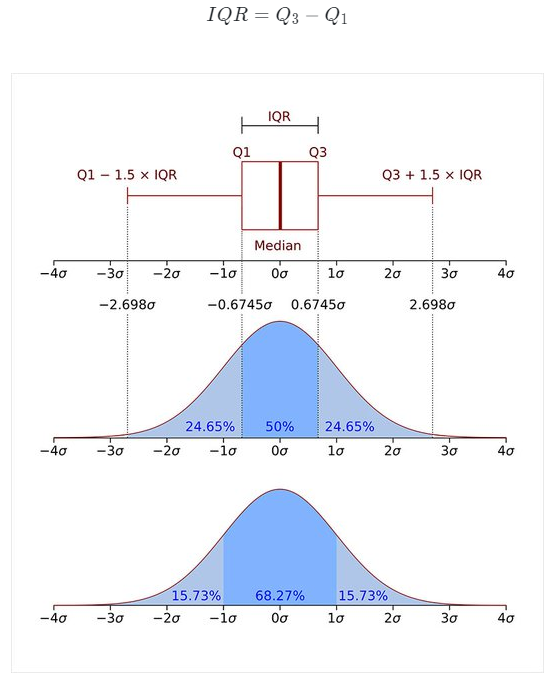


In [749]:

'''
# 위의 방식을 사용하여 연속형 변수 이상치(outlier) 처리
for time_columns in time:
    q1 = np.percentile(train[time_columns], 25)
    q3 = np.percentile(test[time_columns], 75)

    outlier_bounds = q3 + 1.5 * (q3 - q3)
    train.loc[train[time_columns] >= outlier_bounds, time_columns] = outlier_bounds
    test.loc[test[time_columns] >= outlier_bounds, time_columns] = outlier_bounds

train[time].describe()
'''

'\n# 위의 방식을 사용하여 연속형 변수 이상치(outlier) 처리\nfor time_columns in time:\n    q1 = np.percentile(train[time_columns], 25)\n    q3 = np.percentile(test[time_columns], 75)\n\n    outlier_bounds = q3 + 1.5 * (q3 - q3)\n    train.loc[train[time_columns] >= outlier_bounds, time_columns] = outlier_bounds\n    test.loc[test[time_columns] >= outlier_bounds, time_columns] = outlier_bounds\n\ntrain[time].describe()\n'

In [750]:
# familysize의 값을 최대치를 10으로 잡고, 10이 넘어갈 경우 최빈 값으로 변경
train.loc[train.familysize >= 10, 'familysize'] = train['familysize'].mode()[0]
test.loc[test.familysize >= 10, 'familysize'] = test['familysize'].mode()[0]


In [751]:
'''
# train data에 존재하는 상위 6개 나라
best_country = train['country'].value_counts().keys()[:6]

# best country가 아닌 국가는 최빈값으로 처리
for i in range(len(train['country'])):
    if train['country'][i] not in best_country or train['country'][i] == 0:
        train['country'][i] = train['country'].mode()[0]
        
# test data도 동일하게 처리
for i in range(len(test['country'])):
    if test['country'][i] not in best_country or test['country'][i] == 0:
        test['country'][i] = train['country'].mode()[0]
'''

#train.loc[train.country == 0, 'country'] = train['country'].mode()[0]
#test.loc[test.country == 0, 'country'] = test['country'].mode()[0]

# country에 대해 설명력이 부족함 -> 삭제
train.drop(['country'], axis = 1, inplace = True)
test.drop(['country'], axis = 1, inplace = True)

In [752]:
# country 특성 one-hot 인코딩 수행
#train = pd.get_dummies(train)
#test = pd.get_dummies(test)

# -> nerdiness가 사라져

In [753]:
train.columns


Index(['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8', 'Q9', 'Q10', 'Q11',
       'Q12', 'Q13', 'Q14', 'Q15', 'Q16', 'Q17', 'Q18', 'Q19', 'Q20', 'Q21',
       'Q22', 'Q23', 'Q24', 'Q25', 'Q26', 'TIPI1', 'TIPI2', 'TIPI3', 'TIPI4',
       'TIPI5', 'TIPI6', 'TIPI7', 'TIPI8', 'TIPI9', 'TIPI10', 'VCL1', 'VCL2',
       'VCL3', 'VCL4', 'VCL5', 'VCL6', 'VCL7', 'VCL8', 'VCL9', 'VCL10',
       'VCL11', 'VCL12', 'VCL13', 'VCL14', 'VCL15', 'VCL16', 'education',
       'urban', 'gender', 'engnat', 'hand', 'orientation', 'voted', 'married',
       'familysize', 'ASD', 'nerdiness', 'makia_score', 'high_makia', '성실성',
       '우호성', '정서적 안정성', '개방성', '외향성', 'Tactics', 'Views', 'Morality',
       'age_category', 'religion_environment'],
      dtype='object')

In [754]:
# VCL 문제로 지능 수준을 파악
# 존재하지 않는 단어가 중간중간 포함되어 있음.
# nerd한지 파악할 수 있는 증거

VCL_columns = ['VCL' + str(x+1) for x in range(16)]
VCL_not_exists = ['VCL6', 'VCL9', 'VCL12']
VCL_exists = [column for column in VCL_columns if column not in VCL_not_exists]

train['지능'] = (train[VCL_exists].sum(axis = 1) / len(VCL_columns)) + (3 - train[VCL_not_exists].sum(axis = 1)) / len(VCL_columns)
test['지능'] = (test[VCL_exists].sum(axis = 1) / len(VCL_columns)) + (3 - test[VCL_not_exists].sum(axis = 1)) / len(VCL_columns)

train['fake'] = train['VCL6'] + train['VCL9'] + train['VCL12']
test['fake'] = test['VCL6'] + test['VCL9'] + test['VCL12']

In [755]:

train.drop(VCL_columns, axis = 1, inplace = True)
test.drop(VCL_columns, axis = 1, inplace = True)

numeric_columns = train.columns[train.dtypes != 'object']
numeric_columns

categorical_columns = train.columns[(train.dtypes == 'object') & (train.columns != 'nerdiness')]
len(categorical_columns), len(numeric_columns)

(11, 49)

In [756]:
train.columns

Index(['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8', 'Q9', 'Q10', 'Q11',
       'Q12', 'Q13', 'Q14', 'Q15', 'Q16', 'Q17', 'Q18', 'Q19', 'Q20', 'Q21',
       'Q22', 'Q23', 'Q24', 'Q25', 'Q26', 'TIPI1', 'TIPI2', 'TIPI3', 'TIPI4',
       'TIPI5', 'TIPI6', 'TIPI7', 'TIPI8', 'TIPI9', 'TIPI10', 'education',
       'urban', 'gender', 'engnat', 'hand', 'orientation', 'voted', 'married',
       'familysize', 'ASD', 'nerdiness', 'makia_score', 'high_makia', '성실성',
       '우호성', '정서적 안정성', '개방성', '외향성', 'Tactics', 'Views', 'Morality',
       'age_category', 'religion_environment', '지능', 'fake'],
      dtype='object')

In [757]:
# [카테고리] 결측값 -> 최빈값으로 변경

#['gender', 'engnat', 'hand', 'religion', 'orientation', 'voted', 'married', 'ASD', 'urban',  'nerdiness', 'education']
#  float     float     float   float       float      flaot      float     float    int       float   
for category in categorical_columns:
    if category != 'urban':
        train[category] = train[category].astype('float64')
        test[category] = test[category].astype('float64')
    else:
        train[category] = train[category].astype('int64')
        test[category] = test[category].astype('int64')

In [758]:
train.to_csv('C:/Users/tmdwh/Desktop/SEUNGJO/dacon/EDA_VCLDrop_train.csv', index = False)
test.to_csv('C:/Users/tmdwh/Desktop/SEUNGJO/dacon/EDA_VCLDrop_test.csv', index = False)

In [759]:
for numeric in numeric_columns:
    print('{0} column의 왜도 {1:.4f}'.format(numeric, train[numeric].skew()))


Q1 column의 왜도 -0.9885
Q2 column의 왜도 -1.1972
Q3 column의 왜도 1.4591
Q4 column의 왜도 0.7707
Q5 column의 왜도 -0.9031
Q6 column의 왜도 0.6339
Q7 column의 왜도 1.3420
Q8 column의 왜도 -0.9678
Q9 column의 왜도 0.9139
Q10 column의 왜도 1.1142
Q11 column의 왜도 0.1606
Q12 column의 왜도 -0.8517
Q13 column의 왜도 -0.6511
Q14 column의 왜도 0.5904
Q15 column의 왜도 -0.0703
Q16 column의 왜도 0.3775
Q17 column의 왜도 0.8841
Q18 column의 왜도 1.0026
Q19 column의 왜도 -0.3849
Q20 column의 왜도 -0.4999
Q21 column의 왜도 -0.0159
Q22 column의 왜도 0.5872
Q23 column의 왜도 -0.9040
Q24 column의 왜도 -1.4714
Q25 column의 왜도 -0.1770
Q26 column의 왜도 -1.2057
TIPI1 column의 왜도 -0.1143
TIPI2 column의 왜도 -0.8614
TIPI3 column의 왜도 -1.3360
TIPI4 column의 왜도 -0.9022
TIPI5 column의 왜도 -1.4917
TIPI6 column의 왜도 -1.4152
TIPI7 column의 왜도 -1.3476
TIPI8 column의 왜도 -0.7215
TIPI9 column의 왜도 -0.9172
TIPI10 column의 왜도 0.3571
familysize column의 왜도 1.4017
makia_score column의 왜도 0.1571
성실성 column의 왜도 -0.0269
우호성 column의 왜도 0.0114
정서적 안정성 column의 왜도 0.0754
개방성 column의 왜도 -0.4333
외향성 column의 왜도 0.445

In [760]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(train[numeric_columns])
x_scaled = pd.DataFrame(scaler.transform(train[numeric_columns]), columns = numeric_columns)
x_test_scaled = pd.DataFrame(scaler.transform(test[numeric_columns]), columns = numeric_columns)

train_data = pd.concat([train[categorical_columns], x_scaled], axis = 1)
test_data = pd.concat([test[categorical_columns], x_test_scaled], axis = 1)
train_data.shape
test_data.shape

(35452, 60)

In [761]:
train_data.drop(['ASD', 'high_makia'], axis = 1, inplace = True)
test_data.drop(['ASD', 'high_makia'], axis = 1, inplace = True)

여기서부터는 모델


In [762]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder


label_categorical_columns = ['urban', 'gender', 'engnat', 'hand','voted', 'married', 'age_category', 'religion_environment'] + question_columns
onehot_categorical_columns = ['education', 'orientation']
categorical_columns = [] + label_categorical_columns + onehot_categorical_columns
numerical_columns = [columns for columns in test.columns if columns not in ([] + label_categorical_columns + onehot_categorical_columns)]

for label in label_categorical_columns:
    le = LabelEncoder()
    le.fit(train_data[label])
    train_data[label] = le.transform(train_data[label])
    test_data[label] = le.transform(test_data[label])

for onehot in onehot_categorical_columns:
    train_data = pd.get_dummies(train_data, columns = [onehot])
    test_data = pd.get_dummies(test_data, columns = [onehot])

In [763]:
from sklearn.model_selection import train_test_split, cross_val_score

X = train_data
y = train['nerdiness']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size= 0.2, random_state = 42, stratify = y)

In [764]:
from sklearn.model_selection import StratifiedKFold
def tune_model(model_type, X, Y, n_trials=100, cv=10):
    skf = StratifiedKFold(n_splits=cv)
    
    if model_type=='lgb':
        def objective(trial):
            n_estimators = trial.suggest_int('n_estimators', 100, 1000)
            learning_rate = trial.suggest_loguniform('learning_rate', 0.05, 0.3)
            num_leaves = trial.suggest_int('num_leaves', 7, 255)
            reg_alpha = trial.suggest_loguniform('reg_alpha', 1e-4, 10)
            reg_lambda = trial.suggest_loguniform('reg_lambda', 1e-4, 10)
            colsample_bytree = trial.suggest_uniform('colsample_bytree', 0, 1)
            subsample = trial.suggest_uniform('subsample', 0, 1)
            params = {'n_estimators' : n_estimators, 
                     'learning_rate' : learning_rate, 
                      'num_leaves' : num_leaves,
                     'reg_alpha' : reg_alpha,
                     'reg_lambda' : reg_lambda, 
                     'colsample_bytree' : colsample_bytree, 
                     'subsample' : subsample
                     }
            model = lgb.LGBMClassifier(metric='auc', random_state=42, **params)
            score = cross_val_score(model, X, Y, cv=skf, scoring='roc_auc').mean()
            
            return score
    
        
    elif model_type=='rf':
        def objective(trial):
            n_estimators = trial.suggest_int('n_estimators', 100, 1000)
            max_depth = trial.suggest_int('max_depth', 3, 100)
            max_features = trial.suggest_uniform('max_features', 0, 1)
            criterion = trial.suggest_categorical('criterion', ['gini','entropy'])
            params = {'n_estimators' : n_estimators, 
                     'max_features' : max_features, 
                      'max_depth' : max_depth,
                      'criterion' : criterion
                     }
            model = RandomForestClassifier(random_state=42, **params, n_jobs=-1)
            score = cross_val_score(model, X, Y, cv=skf, scoring='roc_auc').mean()
            
            return score
        
        
    elif model_type=='ets':
        def objective(trial):
            n_estimators = trial.suggest_int('n_estimators', 100, 1000)
            max_depth = trial.suggest_int('max_depth', 3, 100)
            max_features = trial.suggest_uniform('max_features', 0, 1)
            criterion = trial.suggest_categorical('criterion', ['gini','entropy'])
            params = {'n_estimators' : n_estimators, 
                     'max_features' : max_features, 
                      'max_depth' : max_depth,
                      'criterion' : criterion
                     }
            model = ExtraTreesClassifier(random_state=42, **params, n_jobs=-1)
            score = cross_val_score(model, X, Y, cv=skf, scoring='roc_auc').mean()
            
            return score
        
    
    sampler = TPESampler(seed=42)
    study=optuna.create_study(direction='maximize', 
                              sampler = sampler)
    study.optimize(objective, n_trials=n_trials)
    print(f"Model : {model_type}, Best Score : {study.best_value}, Best Params : {study.best_params}")
    return study.best_params

In [765]:
from sklearn.ensemble import ExtraTreesClassifier, VotingClassifier, RandomForestClassifier
import lightgbm as lgb
from sklearn.model_selection import train_test_split, cross_val_score

ex_params = {'n_estimators': 500, 'max_depth': 75, 'max_features': 0.20222465942018208, 'criterion': 'entropy'}
rf_params =  {'n_estimators': 400, 'max_depth': 31, 'max_features': 0.05408093225447195, 'criterion': 'entropy'}
lgb_params = {'n_estimators': 189, 'learning_rate': 0.06550029428021084, 'num_leaves': 249, 'reg_alpha': 0.00011906936480932443, 'reg_lambda': 0.00012169645168232884, 'colsample_bytree': 0.2231374650653746, 'subsample': 0.18089704448751198}

ex_clf = ExtraTreesClassifier(**ex_params, random_state = 42)
rf_clf = RandomForestClassifier(**rf_params, random_state = 42)
tuned_lgbm=lgb.LGBMClassifier(objective="binary", random_state=42, **lgb_params)

vt_clf = VotingClassifier(estimators = [
        ('lgbm', tuned_lgbm),
        ('rf', rf_clf),
        ('ex', ex_clf),
    ], weights = (2, 1, 7), voting = 'soft')

score = cross_val_score(vt_clf, X, y, cv = 10, scoring = 'roc_auc')
score.mean(), score.std()

(0.8921728717266963, 0.011232984601497732)

In [766]:
from sklearn.ensemble import ExtraTreesClassifier, VotingClassifier, RandomForestClassifier
import lightgbm as lgb

ex_params = {'n_estimators': 500, 'max_depth': 75, 'max_features': 0.20222465942018208, 'criterion': 'entropy'}
rf_params =  {'n_estimators': 400, 'max_depth': 31, 'max_features': 0.05408093225447195, 'criterion': 'entropy'}
lgb_params = {'n_estimators': 189, 'learning_rate': 0.06550029428021084, 'num_leaves': 249, 'reg_alpha': 0.00011906936480932443, 'reg_lambda': 0.00012169645168232884, 'colsample_bytree': 0.2231374650653746, 'subsample': 0.18089704448751198}

ex_clf = ExtraTreesClassifier(**ex_params, random_state = 42)
rf_clf = RandomForestClassifier(**rf_params, random_state = 42)
tuned_lgbm=lgb.LGBMClassifier(objective="binary", random_state=42, **lgb_params)

vt_clf = VotingClassifier(estimators = [
        ('lgbm', tuned_lgbm),
        ('rf', rf_clf),
        ('ex', ex_clf),
    ], weights = (2, 1, 7), voting = 'soft')

vt_clf.fit(X, y)

predictions = vt_clf.predict_proba(test_data)[:, 1]
submission['nerdiness'] = predictions
submission

,index,nerdiness
0,0,0.093751
1,1,0.796669
2,2,0.884768
3,3,0.577233
4,4,0.956298
...,...,...
35447,35447,0.959114
35448,35448,0.739745
35449,35449,0.951074
35450,35450,0.056970


In [767]:
# !pip install optuna
# optuna를 사용하여 하이퍼 파라미터 최적화

import optuna
from optuna import Trial
from optuna.samplers import TPESampler

In [768]:
from sklearn.model_selection import StratifiedKFold
def tune_model(model_type, X, Y, n_trials=100, cv=10):
    skf = StratifiedKFold(n_splits=cv)
    
    if model_type=='lgb':
        def objective(trial):
            n_estimators = trial.suggest_int('n_estimators', 100, 1000)
            learning_rate = trial.suggest_loguniform('learning_rate', 0.05, 0.3)
            num_leaves = trial.suggest_int('num_leaves', 7, 255)
            reg_alpha = trial.suggest_loguniform('reg_alpha', 1e-4, 10)
            reg_lambda = trial.suggest_loguniform('reg_lambda', 1e-4, 10)
            colsample_bytree = trial.suggest_uniform('colsample_bytree', 0, 1)
            subsample = trial.suggest_uniform('subsample', 0, 1)
            params = {'n_estimators' : n_estimators, 
                     'learning_rate' : learning_rate, 
                      'num_leaves' : num_leaves,
                     'reg_alpha' : reg_alpha,
                     'reg_lambda' : reg_lambda, 
                     'colsample_bytree' : colsample_bytree, 
                     'subsample' : subsample
                     }
            model = lgb.LGBMClassifier(metric='auc', random_state=42, **params)
            score = cross_val_score(model, X, Y, cv=skf, scoring='roc_auc').mean()
            
            return score
    
#     elif model_type=='cat':
#         def objective(trial):
#             params={}
#             params['n_estimators'] = trial.suggest_int('n_estimators', 100, 1000)
#             params['learning_rate'] = trial.suggest_loguniform('learning_rate', 0.01, 0.3)
#             params['depth'] = trial.suggest_int('depth', 3, 8)
#             params['reg_lambda'] = trial.suggest_loguniform('reg_lambda', 1e-4, 30)
#             params['random_strength'] = trial.suggest_uniform('random_strength', 0.1, 30)
            
#             params['bootstrap_type'] = trial.suggest_categorical('bootstrap_type', ['Bayesian','Bernoulli','Poisson'])
#             if params['bootstrap_type'] == 'Bayesian':
#                 params['bagging_temperature'] = trial.suggest_uniform('bagging_temperature', 0, 30)
#             else: 
#                 params['subsample'] = trial.suggest_uniform('subsample', 0, 1)
#             print(params)
#             model = CatBoostClassifier(task_type="GPU", eval_metric='AUC', random_seed=42, **params, verbose=False)
#             model.fit(x_train, y_train, early_stopping_rounds=100, verbose=500, eval_set=(x_test, y_test))
#             score = roc_auc_score(y_test, model.predict_proba(x_test)[:,1])

#             return score
        
        
    elif model_type=='rf':
        def objective(trial):
            n_estimators = trial.suggest_int('n_estimators', 100, 1000)
            max_depth = trial.suggest_int('max_depth', 3, 100)
            max_features = trial.suggest_uniform('max_features', 0, 1)
            criterion = trial.suggest_categorical('criterion', ['gini','entropy'])
            params = {'n_estimators' : n_estimators, 
                     'max_features' : max_features, 
                      'max_depth' : max_depth,
                      'criterion' : criterion
                     }
            model = RandomForestClassifier(random_state=42, **params, n_jobs=-1)
            score = cross_val_score(model, X, Y, cv=skf, scoring='roc_auc').mean()
            
            return score
        
        
    elif model_type=='ets':
        def objective(trial):
            n_estimators = trial.suggest_int('n_estimators', 100, 1000)
            max_depth = trial.suggest_int('max_depth', 3, 100)
            max_features = trial.suggest_uniform('max_features', 0, 1)
            criterion = trial.suggest_categorical('criterion', ['gini','entropy'])
            params = {'n_estimators' : n_estimators, 
                     'max_features' : max_features, 
                      'max_depth' : max_depth,
                      'criterion' : criterion
                     }
            model = ExtraTreesClassifier(random_state=42, **params, n_jobs=-1)
            score = cross_val_score(model, X, Y, cv=skf, scoring='roc_auc').mean()
            
            return score
        
    
    sampler = TPESampler(seed=42)
    study=optuna.create_study(direction='maximize', 
                              sampler = sampler)
    study.optimize(objective, n_trials=n_trials)
    print(f"Model : {model_type}, Best Score : {study.best_value}, Best Params : {study.best_params}")
    return study.best_params

In [769]:
lgb_params = tune_model('lgb', X, y, n_trials=1000)

[I 2023-01-11 00:32:44,280] Trial 0 finished with value: 0.8270957717078261 and parameters: {'n_estimators': 202, 'learning_rate': 0.2083535600888856, 'num_leaves': 21, 'reg_alpha': 0.4570563099801455, 'reg_lambda': 0.09846738873614563, 'colsample_bytree': 0.15601864044243652, 'subsample': 0.15599452033620265}. Best is trial 0 with value: 0.8270957717078261.
[I 2023-01-11 00:32:51,839] Trial 1 finished with value: 0.7986779746086973 and parameters: {'n_estimators': 430, 'learning_rate': 0.1138505423634207, 'num_leaves': 123, 'reg_alpha': 0.10129197956845731, 'reg_lambda': 0.3470266988650412, 'colsample_bytree': 0.020584494295802447, 'subsample': 0.9699098521619943}. Best is trial 0 with value: 0.8270957717078261.
[I 2023-01-11 00:33:48,778] Trial 2 finished with value: 0.8802643601186138 and parameters: {'n_estimators': 591, 'learning_rate': 0.26872369865333173, 'num_leaves': 136, 'reg_alpha': 0.0008111941985431928, 'reg_lambda': 0.0008260808399079611, 'colsample_bytree': 0.30424224295

In [ ]:
rf_params = tune_model('rf', X, y, n_trials=300)

In [ ]:
ets_parm= tune_model('ets', X, y, n_trials=300)